## Plot alignment statistics for revision dicodon barcodeseq

In [1]:
suppressPackageStartupMessages(library(Biostrings))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(rasilabRtemplates))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(plotrix))
suppressPackageStartupMessages(library(ggh4x))

n_barcodes_cutoff <- 2
barcode_reads_cutoff <- 10
reads_per_insert_cutoff <- 100
reads_per_diaa_cutoff <- 500
se_cutoff <- 0.2

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


### Global plotting themes

In [2]:
theme <- theme(
        title = element_text(margin = margin(t=0, r=2, b=2, l=2), size=8),
        axis.title.x = element_text(margin = margin(t=2, r=2, b=0, l=2), size=8),
        axis.title.y = element_text(margin = margin(t=2, r=2, b=2, l=0), size=8),
        text = element_text(size = 8),
        legend.text=element_text(size=8),
        axis.line.x=element_line(size=0.2),
        axis.line.y=element_line(size=0.2),
        axis.ticks.y =  element_line(size=0.2),
        axis.ticks.x = element_line(size=0.2),
        axis.text.x = element_text(size=8),
        axis.text.y = element_text(size=8)
        )

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [3]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Load annotations & counts

In [4]:
sample_annotations = read_csv("../annotations/sample_annotations.csv", comment='#')

Rows: 2 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (11): owner, sample_name, library_type, plasmid_snapgene_map, amplicon_s...
dbl  (3): barcode_read, barcode_start, barcode_length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
strain_annotations <- read_csv("../annotations/strain_annotations.csv", comment='#') %>%
    mutate(`ID` = str_trim(`ID`)) %>%
    mutate(strain = str_trim(strain)) %>%
    mutate(plasmid = str_trim(plasmid)) %>%
    mutate(genotype = str_trim(genotype))

Rows: 7 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): ID, strain, plasmid, genotype, library

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
insert_annotations = read_csv("../../small_8xdicodon_rqcdel_linkage/annotations/insert_annotations.csv") %>%
    mutate(dicodon = str_extract(insert, "([ACTG]{6})(?=\\1{7})")) %>%
    drop_na() %>%
    mutate(diaa = as.character(translate(DNAStringSet(dicodon), no.init.codon = T))) %>%
    mutate(codon1 = substr(dicodon, 1, 3), codon2 = substr(dicodon, 4, 6),
         aa1 = substr(diaa, 1, 1), aa2 = substr(diaa, 2, 2)) %>%
    print()

Rows: 130 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): insert
dbl (1): insert_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 130 × 8
   insert_num insert                     dicodon diaa  codon1 codon2 aa1   aa2  
        <dbl> <chr>                      <chr>   <chr> <chr>  <chr>  <chr> <chr>
 1          1 AAAAAAAAAAAAAAAAAAAAAAAAA… AAAAAA  KK    AAA    AAA    K     K    
 2          2 AAAAAGAAAAAGAAAAAGAAAAAGA… AAAAAG  KK    AAA    AAG    K     K    
 3          3 AAAAGAAAAAGAAAAAGAAAAAGAA… AAAAGA  KR    AAA    AGA    K     R    
 4          4 AAAAGGAAAAGGAAAAGGAAAAGGA… AAAAGG  KR    AAA    AGG    K     R    
 5          5 AAACGAAAACGAAAACGAAAACGAA… AAACGA  KR    AAA    CGA    K     R    
 6          6 AAACGCAAACGCAAACGCAAACGCA… AAACGC  KR    AAA    CGC    K     R    
 7          7 AAACGGAAACGGAAACGGAAACGGA… AAACGG  KR    AAA    CGG    K     R    
 8          8 AAACGTAAACGTAAACGTAAACGTA… AAACGT  KR    AAA    CGT    K     R    
 9          9 AAAGCCAAAGCCAAAGCCAAAGCCA… AAAGCC  KA    AAA    GCC    K     A    
10         10 AAATTCAAATTCAAATTCAAATTCA… AAATTC  KF    AAA    TTC    K     F    
# … with

In [7]:
barcode_counts <- list.files("../data/linked_barcode_counts/", pattern = ".csv$", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(counts = map(file, read_csv)) %>% 
  mutate(sample_id = str_extract(file, "[^/]+(?=.csv)")) %>% 
  select(-sno, -file) %>% 
  unnest() %>% 
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(barcode_count = as.numeric(barcode_count)) %>%
  mutate(linkage_count = as.numeric(linkage_count))

Rows: 10979 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): barcode, sample
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 9232 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): barcode, sample
dbl (4): barcode_count, insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“`cols` is now required when using unnest().
Please use `cols = c(counts)`”


In [8]:
insert_barcode_linkages <- read_csv("../../small_8xdicodon_rqcdel_linkage/data/filtered_barcodes/filtered_barcodes_all_linkage.csv") %>%
  mutate(insert_num = as.numeric(str_extract(insert_num, "[:digit:]+"))) %>%
  mutate(linkage_count = as.numeric(linkage_count)) 

head(insert_barcode_linkages)

Rows: 21862 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): barcode, sample
dbl (3): insert_num, barcode_num, linkage_count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


insert_num,barcode_num,barcode,linkage_count,sample
<dbl>,<dbl>,<chr>,<dbl>,<chr>
83,1,GAGGGCTTTGAGGCTGACTGTGGG,846,89lib2
76,2,GACAATGAGCGGGACGGGTTTAAT,819,89lib2
16,3,GAGTGCGTGATGAGGTGGGGGGGT,784,89lib1
109,4,TTGTGCGAGTGCGCTGATTGTGTG,757,89lib1
104,5,TGTGCGGGGGGTTGCCCGTGCGTG,751,89lib2
103,6,GCTGTGGCTTTTTTGATGTGGGGT,748,89lib1


In [9]:
sample_annotations

owner,sample_name,library_type,plasmid_snapgene_map,amplicon_snapgene_map,illumina_sample_id,sample_id,barcode_read,barcode_start,barcode_length,r1_file,r2_file,run_id,s3_location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
kc,revision_dicodon_mrna,mrna,pHPSC1165-71,lKCSC05,kc_89lib8,89lib8,1,1,24,kc_89lib8_S8_R1_001,kc_89lib8_S8_R2_001,231207_VH00699_402_AAFFN3WM5,fh-pi-subramaniam-a-eco/git_repos/rqc_aggregation_aging/analysis/deepseq/20231208_revision_dicodon_linkageseq/data/fastq
kc,revision_dicodon_grna,grna,pHPSC1165-71,lKCSC05,kc_89lib9,89lib9,1,1,24,kc_89lib9_S9_R1_001,kc_89lib9_S9_R2_001,231207_VH00699_402_AAFFN3WM5,fh-pi-subramaniam-a-eco/git_repos/rqc_aggregation_aging/analysis/deepseq/20231208_revision_dicodon_linkageseq/data/fastq


In [10]:
barcode_insert_counts <- barcode_counts %>% 
  left_join(select(sample_annotations, c(sample_name)), by = c("sample_id"="sample_name")) %>%
  left_join(insert_barcode_linkages, by = c("barcode_num", "barcode", "insert_num", "linkage_count", 'sample')) %>%
  drop_na(barcode_count) %>%
  left_join(strain_annotations, by=c('sample'='library')) %>%
  mutate(library_type = str_extract(sample_id, '(?<=_dicodon_)(.+)$')) %>%
  select(-sample_id, -`ID`, -strain, -plasmid, -sample)

In [11]:
barcode_mrna_grna_counts <- barcode_insert_counts %>%
    filter(barcode_count >= barcode_reads_cutoff) %>%
    select(-linkage_count) %>%
    pivot_wider(names_from=library_type, values_from=barcode_count) %>%
    drop_na() %>%
    left_join(insert_annotations, by='insert_num')

### Note

- Not5-del cells had low read/barcode counts compared to other strains, the data is low quality likely due to growth defects as cited by other groups

In [12]:
lowest_mrna_level_diaa_fig3 <- c('KK', 'WW', 'PG', 'RR', 'KR', 'WK', 'KW', 'PD', 'RK', 'DP', 'FK', 'KF', 'RW', 'WR', 'RI', 'RL', 'IR', 'LR', 'GP', 'AL')
controls <- c('Stop', 'GD', 'KA', 'KG', 'PP', 'KD', 'FG')

In [14]:
order <- barcode_mrna_grna_counts %>% # already filtered for >=10 reads per barcode
    drop_na(dicodon) %>% # drops skvf/svkf
    group_by(genotype, insert_num) %>%
    mutate(n_barc = n(), n_mrna=sum(mrna), n_grna=sum(grna)) %>%
    ungroup() %>%
    filter(n_barc >= n_barcodes_cutoff, n_mrna >= reads_per_insert_cutoff, n_grna >= reads_per_insert_cutoff) %>%
    mutate(lfc = log2(mrna/grna)) %>%
    group_by(genotype, diaa) %>%
    summarize(avg_lfc = mean(lfc), sum_mrna = sum(n_mrna), sum_grna = sum(n_grna), se = std.error(lfc), s=sd(lfc), .groups='drop') %>%
    filter(sum_mrna >= 500, sum_grna >= 500) %>%
    filter(se <= 0.2) %>%
    filter(genotype != 'Not5') %>%
    mutate(diaa = ifelse(diaa == '**', 'Stop', diaa)) %>%
    group_by(diaa) %>%
    mutate(n_strains = n()) %>%
    ungroup() %>%
    filter(n_strains > 1) %>%
    mutate(type = case_when(diaa %in% lowest_mrna_level_diaa_fig3 ~ 'Diaa with lowest\nmRNA levels',
                            diaa %in% controls ~ 'Control diaa')) %>%
    arrange(genotype, type) %>%
    mutate(diaa = str_c(diaa, ',', type)) %>%
    dplyr::pull(diaa) %>%
    unique()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


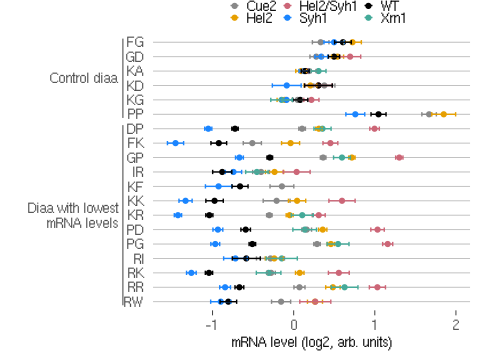

In [15]:
barcode_mrna_grna_counts %>% # already filtered for >=10 reads per barcode
    mutate(total_mrna = sum(mrna), total_grna = sum(grna)) %>%
    mutate(norm_mrna = mrna/total_mrna, norm_grna = grna/total_grna) %>%
    drop_na(dicodon) %>% # drops skvf/svkf
    group_by(genotype, insert_num) %>%
    mutate(n_barc = n(), mrna_per_insert=sum(mrna), grna_per_insert=sum(grna)) %>%
    ungroup() %>%
    filter(n_barc >= n_barcodes_cutoff, mrna_per_insert >= reads_per_insert_cutoff, grna_per_insert >= reads_per_insert_cutoff) %>%
    mutate(lfc = log2(norm_mrna/norm_grna)) %>%
    group_by(genotype, diaa) %>%
    summarize(avg_lfc = mean(lfc), mrna_per_diaa = sum(mrna_per_insert), grna_per_diaa = sum(grna_per_insert), se = std.error(lfc), s=sd(lfc), .groups='drop') %>%
    filter(mrna_per_diaa >= reads_per_diaa_cutoff, grna_per_diaa >= reads_per_diaa_cutoff) %>%
    filter(se <= se_cutoff) %>%
    filter(genotype != 'Not5') %>%
    mutate(diaa = ifelse(diaa == '**', 'Stop', diaa)) %>%
    group_by(diaa) %>%
    mutate(n_strains = n()) %>%
    ungroup() %>%
    filter(n_strains > 1) %>%
    mutate(type = case_when(diaa %in% lowest_mrna_level_diaa_fig3 ~ 'Diaa with lowest\nmRNA levels',
                            diaa %in% controls ~ 'Control diaa')) %>%
    mutate(diaa1 = str_c(diaa, ',' ,type)) %>%
    mutate(diaa = factor(diaa1, levels=rev(order))) %>%
    drop_na(diaa) %>%
    ggplot() +
    aes(y=diaa, x=avg_lfc, xmin=avg_lfc-se, xmax=avg_lfc+se, color=genotype) +
    geom_point(size=0.7) +
    geom_errorbar(width=0.3, size=0.3) +
    scale_y_discrete(guide = guide_axis_nested(delim = ",")) +
    theme + 
    theme(legend.position = "top",
        axis.line.x = element_blank(),
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.grid.major.y = element_line(color='grey', size=0.2),
        legend.key.height = unit(2.5, 'mm'),
        legend.key.width = unit(2, 'mm'),
        legend.text = element_text(size=8),
        legend.title = element_text(size=8),
        legend.box.margin=margin(-12,-12,-12,-12),
        ggh4x.axis.nestline = element_line(linewidth = 0.2),
        ggh4x.axis.nesttext.y = element_text(),
        ) +
    scale_color_manual(values=c('WT'='black', 'Hel2'='#E69F00', 'Syh1' = '#1A85FF', 'Hel2/Syh1'='#CC6677', 'Cue2'='#888888', 'Xrn1'='#44AA99')) +
    labs(y='', x='mRNA level (log2, arb. units)', color='')

ggsave("../figures/diaa_pass_filters_norm.pdf", height=4.2, width=3)